In [1]:
import os
from matplotlib import pyplot as plt
import librosa
import IPython.display as ipd
import tensorflow as tf
import warnings              

In [2]:
CAPUCHIN_FILE = os.path.join('audio_dataset', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('audio_dataset', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [3]:
ipd.Audio(CAPUCHIN_FILE)

In [4]:
ipd.Audio(NOT_CAPUCHIN_FILE)

In [5]:
def load_aud(audio_dataset):
    wave, sample_rate = librosa.load(audio_dataset, sr=None)  # sr=None returns the original sample rate
    return wave, sample_rate


In [6]:
ywave, sr_y = load_aud(CAPUCHIN_FILE)
nwave, sr_n = load_aud(NOT_CAPUCHIN_FILE)

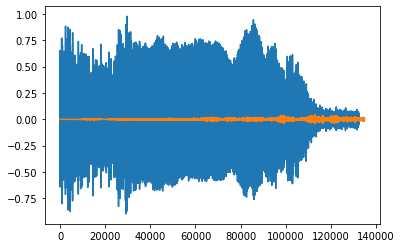

In [7]:
plt.plot(ywave)
plt.plot(nwave)
plt.show()

In [17]:
CAPUCHIN_FILE = os.path.join('audio_dataset', 'Parsed_Capuchinbird_Clips')
NOT_CAPUCHIN_FILE = os.path.join('audio_dataset', 'Parsed_Not_Capuchinbird_Clips')

In [18]:
# Creating the tensorflow Dataset using the list_files method from tensorflow
Positive_dataset = tf.data.Dataset.list_files(CAPUCHIN_FILE+'/*.wav') # positive dataset / capuchin bird
Negative_dataset = tf.data.Dataset.list_files(NOT_CAPUCHIN_FILE+'/*.wav') # negative dataset / non capuchin bird

In [19]:
# Adding labels and Combining positive and negative samples using zip from tensorflow
Positive_Samples = tf.data.Dataset.zip((Positive_dataset, tf.data.Dataset.from_tensor_slices(tf.ones(len(Positive_dataset)))))  # positive sample / capuchin bird call
Negative_Samples = tf.data.Dataset.zip((Negative_dataset, tf.data.Dataset.from_tensor_slices(tf.zeros(len(Negative_dataset))))) # negative sample / non capuchin bird call
# Defining data using the samples 
data = Positive_Samples.concatenate(Negative_Samples)  

In [20]:
import librosa

def Loading_wav_16k_mono_librosa(filename):
    try:
        # Loading the encoded wav file using librosa
        wav, rate_sample = librosa.load(filename, sr=16000, mono=True)
        return wav
    except Exception as e:
        print(f"Error loading audio file {filename} with librosa: {e}")
        return None


In [21]:
# Creating a loop for calculating the wave cycle length
lengthsArray = []
for file in os.listdir(os.path.join('audio_dataset', 'Parsed_Capuchinbird_Clips')):   # gets through the files using os 
    tensor_wave = Loading_wav_16k_mono_librosa(os.path.join('audio_dataset', 'Parsed_Capuchinbird_Clips', file)) # load the files into a wave format
    lengthsArray.append(len(tensor_wave)) # checks how long each wave are

In [22]:
# Checking the mean of the lengthsArray using reduce_mean from tensorflow
tf.math.reduce_mean(lengthsArray)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [23]:
tf.math.reduce_min(lengthsArray)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [24]:
tf.math.reduce_max(lengthsArray)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [25]:
# Building the pre_processor function
def preprocessor(file_path, label): 
    WAV = Loading_wav_16k_mono_librosa(file_path)  # loads the data into its waveform
    WAV = WAV[:48000] # taking the first 48000 steps of all signals
    zero_filler = tf.zeros([48000] - tf.shape(WAV), dtype=tf.float32)  # checks if audio length is large, then fill above 48000 steps with 0
    WAV = tf.concat([zero_filler, WAV],0)   # overriding zeros using tf.concat method
    # creating the spectogram
    spectrogram = tf.signal.stft(WAV, frame_length=320, frame_step=32) # short time fourier transform is used for converting the data into spectogram
    spectrogram = tf.abs(spectrogram)  # convert the spectogram into absolute set of values
    spectrogram = tf.expand_dims(spectrogram, axis=2) # ensure that the spectogram is in the appropriate format that we need
    return spectrogram, label  # returns the spectogram, and label

In [26]:
# Testing the pre_processor function and visualizing the spectogram for capuchin bird call
filepath, label = Positive_Samples.shuffle(buffer_size=10000).as_numpy_iterator().next() # numpy iterator() & next() allows us to get the next example out of positive sample data

In [27]:
spectrogram, label = preprocessor(filepath, label) 

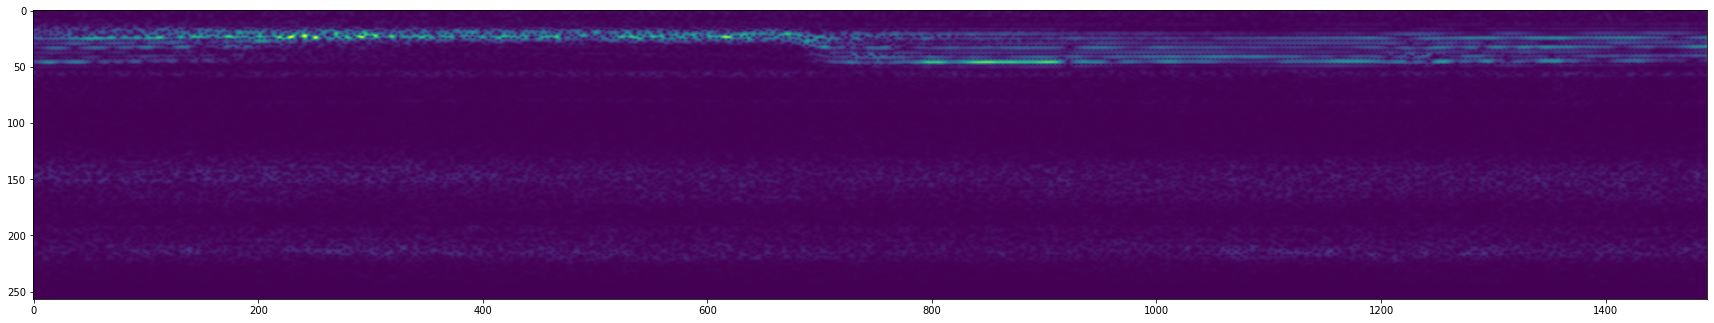

In [28]:
# Visualizing the Positive Data / Capuchin Bird
plt.figure(figsize=(30,20))              # setting the figure size
plt.imshow(tf.transpose(spectrogram)[0]) # setting the spectogram
plt.show()                               # showing the spectogram 
